In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from typing import Tuple
from custom_types import Batch

import jax
import jax.numpy as jnp

import haiku as hk
import optax

from data import get_data, decimate, normalize
from train import network_and_loss, do_training, update_params, net_accuracy
from models.models import lenet_fn

from pruning.pruning import masked_update, imp, threshold_prune

from coherence.coherence import ptwise, get_coherence, subnetwork_coherence

from functools import partial

import utils

In [24]:
# load mnist data
train, train_eval, test_eval = get_data("mnist",batch_size=100,format_fun=normalize)

# cnn, loss, params
net, xent_loss = network_and_loss(lenet_fn)

key = jax.random.PRNGKey(42)
params = net.init(key, next(train)["image"])

# optimization of network
opt = optax.adam(1e-3)
opt_state = opt.init(params)
accuracy_fn = net_accuracy(net)

hs = []

def calc_coherence(loss_fn):

    # @jax.jit
    def helper(
      params: hk.Params,
      batch: Batch,
    ) -> Tuple[hk.Params, optax.OptState]:

        ptwise_fn = ptwise(loss_fn)
        pt_grads = ptwise_fn(params, batch)

        c = get_coherence(pt_grads)
        c_flat = utils.ravel_pytree(c)

        h = jnp.histogram(c_flat, bins=100)
        hs.append(h)

    return helper
    


def train_fn_trace():

    update_fn = update_params(opt,xent_loss)
    aux_fn = calc_coherence(xent_loss)
    final_params = do_training(
                    update_fn, accuracy_fn, 
                    params, opt_state, 
                    train, train_eval, test_eval, 
                    epochs=1001, 
                    aux_fn=aux_fn,
                    aux_epoch=100,
                    )

    return final_params


train_fn_trace();


2022-07-19 21:15:46.239176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-19 21:15:46.248098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[Step 0] Train / Test accuracy: 0.130 / 0.110.
[Step 1000] Train / Test accuracy: 0.970 / 0.980.


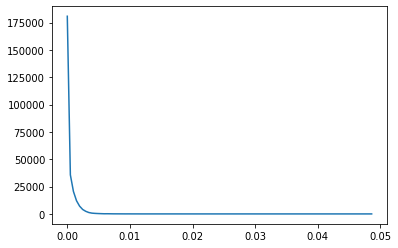

In [30]:
import matplotlib.pyplot as plt
ind = 1
plt.plot(hs[ind][1][:-1],hs[ind][0]);

In [14]:
hs[0]

(DeviceArray([2.49423e+05, 1.35790e+04, 2.33400e+03, 7.65000e+02,
              2.78000e+02, 9.80000e+01, 7.10000e+01, 2.80000e+01,
              1.60000e+01, 8.00000e+00, 5.00000e+00, 2.00000e+00,
              1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
              0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00],            dtype=float32),
 DeviceArray([0.        , 0.00219338, 0.00438676, 0.00658014, 0.00877352,
              0.0109669 , 0.01316028, 0.01535366, 0.01754704, 0.01974042,
              0.0219338 , 0.02412718, 0.02632056, 0.02851394, 0.03070732,
              0.0329007 , 0.03509408, 0.03728746, 0.03948084, 0.04167422,
              0.0438676 ], dtype=float32))